In [3]:
# pip install covsirphy --upgrade
# pip install "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy"
# pip install dataloader
# pip install torch

In [25]:
import pandas as pd
import covsirphy as cs
import pprint
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import odeint
from scipy.odr import Model, Data, ODR
from scipy.fftpack import fft, ifft, fftfreq

%matplotlib inline
import matplotlib.pyplot as plt
import datetime

# cs.get_version()

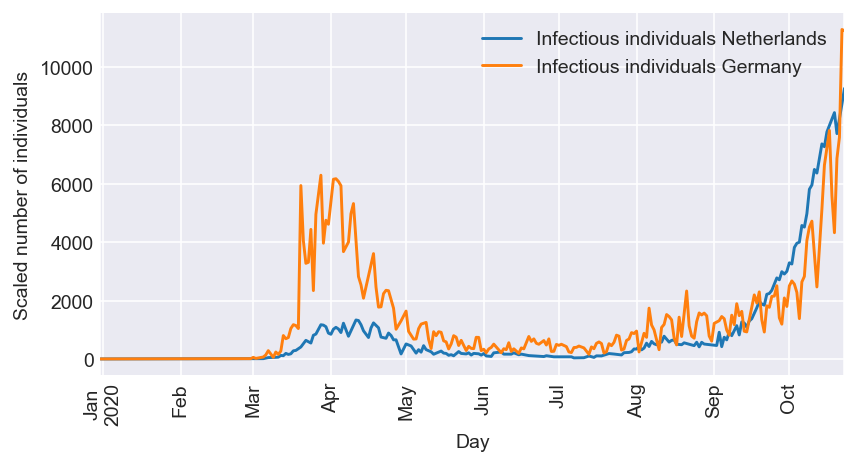

In [3]:
df = pd.read_csv("/Users/Rada/Desktop/Project_Intro/download")

def get_country(df, countryname):
    
    df = df[df['countriesAndTerritories']==countryname]
    df = df.reindex(index=df.index[::-1])
    df = df.set_index('dateRep')
    df.index = pd.to_datetime(df.index,format='%d/%m/%Y')

    return df 

def plot_country(country,countryname,population):
    plt.style.use('seaborn-darkgrid')

    
#     cases = [i/population for i in country['cases']]
    country['cases'].plot(label='Infectious individuals '+str(countryname))
#     plt.plot(country['deaths'],label='Death individuals')

    plt.ylabel('Scaled number of individuals')
    plt.xlabel('Day')
    plt.xticks(rotation=90)
    plt.legend()


pop_nl = 17280000
pop_germ = 82.02*10**6

my_dpi=140
plt.figure(figsize=(960/my_dpi, 480/my_dpi), dpi=my_dpi)

nl = get_country(df, 'Netherlands')
germ = get_country(df, 'Germany')
plot_country(nl,'Netherlands',pop_nl)
plot_country(germ,'Germany',pop_germ)



beta gamma: [7.45761168 7.37533309] found after fitting
Standard deviations found after fitting: [0.0724836  0.07246299]


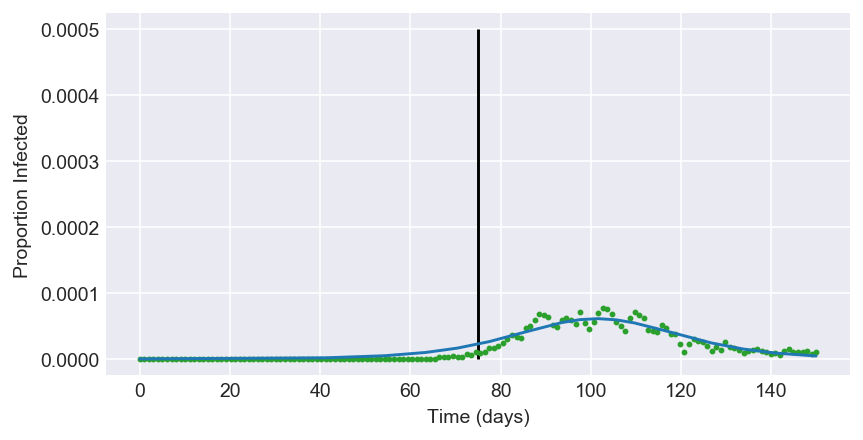

beta gamma: [0.09138323 0.02909035] found after fitting
Standard deviations found after fitting: [0.05626183 0.05800408]


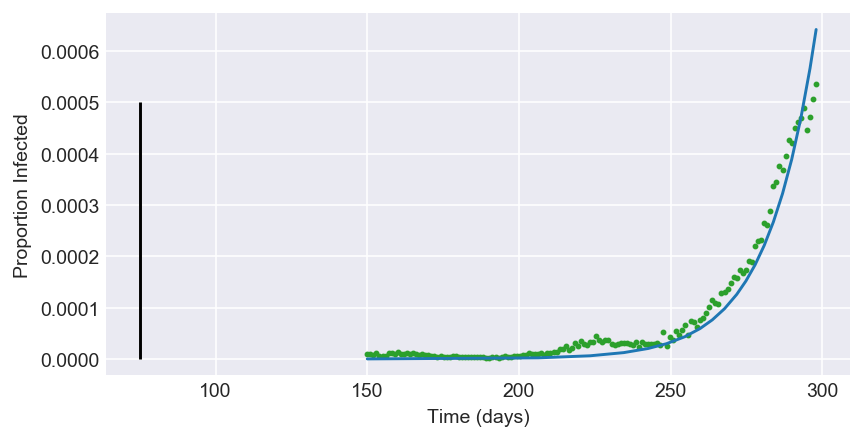

In [4]:
def SIR(y,t,beta,gamma):
    """Ordinary Differential Equations of the basic SIR model"""
    S0,I0,R0 = y
    dSdt = - beta * S0 * I0
    dIdt = beta * S0 * I0 - gamma * I0
    dRdt = gamma * I0   
    return [dSdt, dIdt, dRdt] 


def get_cases(country=nl,citizens=17280000):
    # Convert experimental numbers to proportions
    number = [i for i in country['cases']]
    # prop = [i/(17*10**6) for i in number]
    prop = [i/citizens for i in number]

    return prop

propgerm = get_cases(germ)
propnl = get_cases()


def plot_cases_sir(timepoint1=0,timepoint2=150,beta_guess=[1, 0.8],prop=propnl,population=pop_nl,
                  measure_day=75,max_val=0.0005):

        
    def solveODEs(param,t):
        """Solves differential equations"""
        beta,gamma = param

         # define differential equations
        def SIR(y_0, t):
            """The Ordinary Differential Equations for the basic SIR model"""
            dSdt = - beta * y_0[0] * y_0[1]
            dIdt = beta * y_0[0] * y_0[1] - gamma * y_0[1]
            dRdt = gamma * y_0[1]
            return [dSdt, dIdt, dRdt] 

        return odeint(SIR, y_0, t)[:,1]

    # Times at which the solution is to be computed
    t = np.linspace(timepoint1,timepoint2,timepoint2-timepoint1)

    # Create a Data object using our initiated data from above.
    data = Data(t, prop) 

    # Define initial conditions
    I_0 = 1/17280000
    R_0 = 0.0
    S_0 = 1
    y_0 = [S_0, I_0, R_0]

    # Store information of solveODEs function 
    model = Model(solveODEs) 
    # # Set up ODR with the model, data and initial parameter estimate.
    odr = ODR(data, model, beta0=beta_guess) 
    # # Run the regression
    out = odr.run() 
    beta,gamma=out.beta

    print("beta gamma: {} found after fitting".format(out.beta))
    print("Standard deviations found after fitting: {}".format(out.sd_beta))

    #Plot proportion infected over time 
    plt.figure(figsize=(960/my_dpi, 480/my_dpi), dpi=my_dpi)
    plt.plot(t, prop,'ro',color='tab:green',markersize=2)
    plt.plot(t, solveODEs((beta,gamma),t),color='tab:blue',markersize=10)
    plt.xlabel('Time (days)')
    plt.ylabel('Proportion Infected')
    plt.grid(True)
    plt.vlines(measure_day,0,max_val)
    # plt.savefig('model_fit.png')
    plt.show()
    
    
# plot_cases_sir(prop=propgerm[:150],population=pop_germ)
# plot_cases_sir(timepoint1=150,timepoint2=len(germ),
#                beta_guess=[.09, .05],prop=propgerm[150:len(germ)],
#                population=pop_germ,measure_day=153,max_val=0.0006)

plot_cases_sir(prop=propnl[:150])
plot_cases_sir(timepoint1=150,timepoint2=len(nl),beta_guess=[.09, .05],prop=propnl[150:len(nl)])

In [5]:
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
japan_data = data_loader.japan()
pop_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Detailed citaition list:
Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSE

In [15]:
# Show dataset
_out_df = df.copy()
_out_df

out_df = df.copy()
out_df

,Date,Country,Province,Susceptible,Infected,Fatal or Recovered
0,2020-01-01,Full,SIR,999000,1000,0
1,2020-01-02,Full,SIR,998787,1133,80
2,2020-01-03,Full,SIR,998546,1283,170
3,2020-01-04,Full,SIR,998273,1454,273
4,2020-01-05,Full,SIR,997964,1647,389
...,...,...,...,...,...,...
176,2020-06-25,Full,SIR,88258,749,910992
177,2020-06-26,Full,SIR,88245,708,911047
178,2020-06-27,Full,SIR,88233,669,911098
179,2020-06-28,Full,SIR,88222,632,911146


## Population pyramid

In [26]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk("/Users/Rada/Desktop/Project_Intro/archive"):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head()

,Age,Country,F,M,Year
0,0-4,Sweden,290553,307116,2019
1,5-9,Sweden,288817,304759,2019
2,10-14,Sweden,280944,296771,2019
3,15-19,Sweden,257677,270840,2019
4,20-24,Sweden,274760,291723,2019


In [27]:
pyramid_raw["Country"].unique()

array(['Sweden', 'Canada', 'India', 'France', 'China', 'Italy', 'Spain',
       'Iran', 'Germany', 'United Kingdom', 'United States of America',
       'Japan', 'Netherlands'], dtype=object)

In [28]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Sweden
_male = [
    307116, 304759, 296771, 270840, 291723, 376952, 343311, 315086,
    312017, 336452, 342117, 306949, 279609, 265511, 273061, 195029,
    113166, 61775, 26170, 6768, 415
]
_female = [
    290553, 288817, 280944, 257677, 274760, 361526, 330153, 300752,
    301288, 327453, 331458, 300084, 280009, 272149, 286879, 212480,
    143654, 97633, 52624, 18130, 1771
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Sweden",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Netherlands
_male = [
    5534962, 5820604, 5538414, 5383822, 5149849, 4710777, 4061897, 3581091, 3237426,
    2832825, 2482953, 2015857, 1556935, 1082875, 668107, 364200, 199400, 73508,
    17327, 3035, 208
]
_female = [
    5240508, 5541514, 5273495, 5029137, 4896316, 4589506, 3982681,
    3544279, 3191565, 2825286, 2521463, 2112380, 1714689, 1285782,
    895866, 567282, 360751, 155294, 57969, 13376, 1411
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Netherlands",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df

,Canada,China,France,Germany,Global,India,Iran,Italy,Japan,Netherlands,Spain,Sweden,UK,US
Age,,,,,,,,,,,,,,
0,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
1,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
2,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
3,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
4,395971,17008206,733844,797488,135588358,23356364,1516560,476509,981106,2155094,403236,119533,790209,3920819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910
119,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910
120,352,2949,808,769,24931,1947,21,694,3182,70,535,95,667,3910


In [29]:
df = pyramid_df.cumsum()
countries = df.columns[:]
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], countries]
df[countries] = df[countries].diff()
df.loc[df.index[0], countries] = _first
df[countries] = df[countries].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
out_df

KeyError: 'Age_last'

In [30]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

### SIR model

#### SIR-D model

SIR
{'step_n': 180, 'population': 1000000, 'param_dict': {'rho': 0.2, 'sigma': 0.075}, 'y0_dict': {'Susceptible': 999000, 'Infected': 1000, 'Fatal or Recovered': 0}}


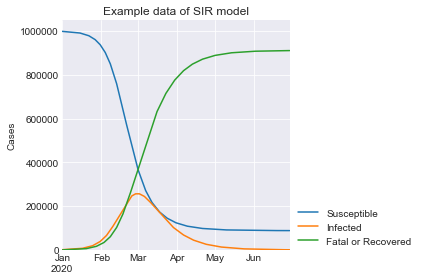

xmax: 	 0.366211 
1/RO: 	0.37453183520599254
preset_dict {'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}
pop_data <covsirphy.cleaning.population.PopulationData object at 0x7ff4e37f1d50>


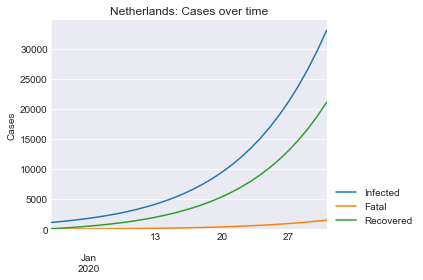

,Date,Confirmed,Infected,Fatal,Recovered
0,2020-01-02,1213,1127,6,80
1,2020-01-03,1451,1270,12,169
2,2020-01-04,1720,1430,19,271
3,2020-01-05,2025,1612,28,385
4,2020-01-06,2366,1816,37,513


,Date,Confirmed,Infected,Fatal,Recovered
25,2020-01-27,35218,21210,940,13068
26,2020-01-28,39544,23730,1061,14753
27,2020-01-29,44357,26524,1196,16637
28,2020-01-30,49704,29616,1347,18741
29,2020-01-31,55633,33030,1515,21088


rho_before actions taken 0.2


KeyError: 'Population pyramid data of Netherlands is not defined!'

In [31]:
# Set tau value and start date of records
# For explanation, the start date will be 01Jan2020
# This is not based on actual data
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

# Model name
print(cs.SIR.NAME)
# Example parameter values
print(cs.SIR.EXAMPLE)

model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

# define R0
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)

# define Xmax
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]

print('xmax: \t {} \n1/RO: \t{}'.format(x_max, 1/eg_r0))

# Preset of SIR-F parameters
preset_dict = cs.SIRF.EXAMPLE["param_dict"]
print('preset_dict',preset_dict)

area = {"country": "Netherlands"}
# Create dataset from 01Jan2020 to 31Jan2020
example_data.add(cs.SIRF, step_n=30, **area)

# Set population value
pop_data.update(cs.SIRF.EXAMPLE["population"], **area)
pop_data.value(**area)

# # Register population value
pop_data.update(cs.SIRF.EXAMPLE["population"], **area)
pop_data.value(**area)

# example_data
print('pop_data',pop_data)

# Show records with Scenario class
snl = cs.Scenario(example_data, pop_data, tau=1440,**area)
record_df = snl.records()
display(record_df.head())
display(record_df.tail())

# Value of beta before actions are taken
rho_before = cs.SIRF.EXAMPLE["param_dict"]["rho"]
print('rho_before actions taken',rho_before)

eg_out_df = go_out("Netherlands")
print('eg_out_df',eg_out_df)

gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
print('gs_before',gs_before)


In [32]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

go_out("Global")

KeyError: 'Population pyramid data of Global is not defined!'

In [333]:
# Set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()
# Add main scenario: the same parameter to 31Dec2020
snl.add(end_date="31Dec2020", name="Main")
# Add lockdown scenario
snl.clear(include_past=False, name="Lockdown")
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_after).summary()

NameError: name 'rho_after' is not defined